## 課題提出時（2018/11/25）の所感
sprint9で勾配降下法を学びましたが、sprint10では拡張性のあるclass化の考え方（オブジェクト思考）を学べて非常に勉強になったsprintでした。この課題の目的は達成できたのでは無いかと思います。  

<教えていただきたいこと>  
・House Pricesの回帰の方では、dropoutの実装も入れてみましたが、この実装で問題無いかどうか。ちなみにPredictの方には入れていません。  
・MNISTの分類では、lossの下がり具合がイマイチでした。Sprint9の時はうまく行っていましたが原因が分かりませんでした。また、accuracy_scoreがうまく実行されませんでした。こちらも原因がわかりませんでした。  

<出来ていないこと>  
・層の数を変えた場合の検証（実装できたのは３層だけでした）  
・複数の活性化関数の実装ができなかった（今回は「tanh」だけでした）  
・複数の重みの初期化の実装ができなかった  
・複数の最適化の実装ができなかった（今回はSGDだけ）  

# 1.この課題の目的
・スクラッチを通してニューラルネットワークの発展的内容を理解する  
・コードをオブジェクト指向で書き換える経験をする 

# 2.進め方
・スクラッチで実装する。（1日目〜2日目）  
・手法の説明を記述する。（2日目夜発表）  

# 3.スクラッチによる実装
NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していく。TensorFlowなどは使用しない。

前回のsprint9で作成した3層のニューラルネットワークを、クラスを活用することで、任意の構成に拡張しやすいコードに書き換えていく。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていく。

今回確認する  
・オブジェクト指向

データセットの用意  
MNISTデータセットを使用する。以下のコードを実行すればscikit-learnによりデータセットをダウンロードし、展開まで行える。はじめて実行した際に、mnist_dirで指定した場所にファイルがダウンロードされる。

# 活性化関数

In [1]:
# 活性化関数
class ReLU:
    
    def __init__(self):
        #mask
        pass
        
    def forward(self, x):
        return np.maximum(0, x)
    
    def backward(self, x):
        return np.where(x > 0, 1, 0)
    

In [2]:
# 活性化関数
class Tanh:
    
    def __init__(self):
        self.forward_A = None
    
    def forward(self, x):
        # backwardの時に必要なのでインスタンス変数として保持
        self.forward_A = x
        return np.tanh(x)
    
    def backward(self, delta):
        # ∂L/∂A2 = ∂L/∂z2 * (1 - tanh(A2)**2)
        #(10, 200) アダマール積 (10, 200) => (10, 200)
        delta = delta * (1 - np.tanh(self.forward_A)**2)
        return  delta

In [3]:
# 出力層の活性化関数
# ソフトマックス関数（MNIST用）
class Softmax:
    def __init__(self):
        self.forward_A = None
        self.y_pred = None
        
    def forward(self,x):
        self.forward_A = x
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            self.y_pred = y.T
        else:
            x = x - np.max(x)
            self.y_pred = np.exp(x) / np.sum(np.exp(x))
        return self.y_pred
    
    def backward(self, delta):
        delta = self.y_pred - delta
        return delta

# Optimizer（最適化手法のクラス化）
初期化方法同様に全結合層にインスタンスとして渡したい。  
バックワードの時にself = self.optimizer.update(self)のように更新できるようにする。

In [4]:
class SGD:
    """
    確率的勾配降下法
    lr  :  学習率
    """
    def __init__(self, lr=0.001):
        self.lr = lr
    
    
    """
    ある層の重みやバイアスの更新
    --------------
    layer   :   更新前の層のインスタンス
    layer   :   更新後の層のインスタンス
    """
    def update(self, layer):
        
        layer.W = layer.W - self.lr * layer.dW / layer.dB.shape[0]
        layer.B = layer.B - self.lr * layer.dB.mean(axis=0)
        
        return layer

In [5]:
class AdaGrad:
    def __init__():
        self.lr = 0.001
        
    def update():
        pass    

# 目的関数（損失関数）

In [6]:
# 平均2乗和誤差
import numpy as np

class MeanSquardError:
    def __init__(self):
        pass
    
    def mse(self, y, y_pred):
        # y  :  正解ラベル
        # y_pred  :  予測値
        #print("aaaa")
        #print("y.shape, y_pred.shape",y.shape, y_pred.shape)
        return np.mean((y - y_pred)**2)/2
        #print(y-y_pred)
        #return np.average((y - y_pred)**2)
        # lenで割ってはだめです。sumが要素全てを加算しているので。回帰の場合であればyのshapeが（X,）なので問題ないが、
        # 分類問題は扱えないので
        #return np.sum((y - y_pred)**2) / len(y)
    
    def backward(self, y, y_pred):
        return y_pred - y

In [7]:
# 交差エントロピー誤差
class CrossEntropyError:
    def __init__(self):
        pass
    
    def cee(self, y_pred, y_train):
        if y_pred.ndim == 1:
            y_train = y_train.reshape(1, y_train.size)
            y_pred = y_pred.reshape(1, y_pred.size)
    
        batch_size = y_pred.shape[0]
        #ミニバッチ単位の損失
        return -np.sum(y_train * np.log(y_pred + 1e-7)) / batch_size
    
#     def backward(self, y, y_pred):
#         return y_pred - y

# Initializer（初期化）
全結合層のコンストラクタに初期化方法のインスタンスを渡したい。

In [8]:
class SimpleInitializer:
    
    """
    ガウス分布によるシンプルな初期化
    sigma  :  float
    """
    def __init__(self, sigma):
        self.sigma = sigma
    
    """
    重みの初期化メソッド
    n_nodes1 :  int   前の層のノード数
    n_nodes2 :  int　　　後の層のノード数
    """
    def W(self, n_nodes1, n_nodes2):
        # 重み（n_nodes1　×　n_nodes2の配列を作成）
        #W = self.sigma*np.random.randn(n_nodes1, n_nodes2)
        W = self.sigma*np.random.rand(n_nodes1, n_nodes2)
        return W
    
    """
    バイアスの初期化メソッド
    n_nodes2  :  int  後の層のノード数
    """
    def B(self, n_nodes2):
        # バイアス
        #B = self.sigma*np.random.randn(n_nodes2)
        B = self.sigma*np.random.rand(n_nodes2)
        #print("いつ変わった？？",B.shape)
        return B

In [9]:
class XavierInitializer:
    def __init__(self):
        pass

In [10]:
class HeInitializer:
    def __init__(self):
        pass
    
    def W():
        pass
    
    def B():
        pass

# ミニバッチ

In [11]:
class GetMiniBatch():
    """
    ミニバッチを取得するイテレータ
    
    Parameters
    ---------------------
    X　:　学習データ
    y　:　正解値
    batch_size : int
    seed : int　　　NumPyの乱数のシード
    
    ---------------------
    for文で呼び出すと以下の２つを返す
    mini_X  : 学習データのミニバッチ 
    mini_y  : 正解値のミニバッチ
    """
    
    def __init__(self, X, y, batch_size=10, seed=0):
        
        # バッチサイズを指定
        self.batch_size = batch_size
        
        # ランダムに並べ換える
        np.random.seed(seed)
        
        # 48,000行、列？のベクトルが作成される
        # 中身は1から48,000の整数値がランダムにセットされる
        # なるほど、名前からしてそうだね。シャッフルインデックス。。
        #print("testコード", X.shape[0])
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._counter = 0
        
        # イテレーション数を計算する
        # 48,000行/10 = 4,800回となる
        # np.ceilは切り上げする関数
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        # len()が使われたときの処理
        return self._stop
        
    def __iter__(self):
        return self
        
    def __next__(self):
            
        # for文で呼ばれた際のループごとの処理
        if self._counter >= self._stop:
                
            # 最後まで進んだら終了
            self._counter = 0 # カウンターをリセット
            raise StopIteration()
        
        
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
            
        self._counter = self._counter + 1
            
        return self.X[p0:p1], self.y[p0:p1]
        

# 全結合層

In [12]:
class Full_Connection:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    n_nodes1 :  int
    n_nodes2 :  int
    initializer :  初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    
    # コンストラクタで重みやバイアスの初期化をする
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):

        # 全結合層のコンストラクタに初期化方法のインスタンスを渡したい
        # ノード数を保持する
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.sigma = initializer.sigma
        
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        # 重み・バイアスを初期化
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        #print("doudesuka",n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        #print("★★★★★★★",self.B.shape)
        
        # 引数で受け取ったoptimizer（最適化クラス）をインスタンス変数として持つ
        self.optimizer = optimizer
        
        # ここで初期化が必要。。
        self.X = None
        self.dB = None
        self.dW = None
        self.A = None
        
        # ドロップアウト用
        self.mask = None
        self.dropout_ratio = 0.5
    
    def forward(self, X):
        """
        X  :  配列とシェイプ  （batch_size,  n_nodes1）
        A  :  配列とシェイプ  （batch_size, n_nodes2）
        """
        """
        ドロップアウトする要素（False）としない要素（True）に分ける
        """
        self.X = X.copy()
        self.mask = np.random.rand(*self.X.shape) > self.dropout_ratio
        self.X = self.X * self.mask
        
        # 入力Xをインスタンス変数として保持
        self.X = X.copy()
        
        # 全結合はここで定義している
        self.A = np.dot(self.X, self.W) + self.B
        
        return self.A

    
    def backward(self, dA):
        
        """
        dA  :  後ろから流れてきた勾配(batch_size, n_nodes2)
        dZ  :   前に流す勾配　（batch_size, n_nodes1）
        """
        # バイアスの勾配は、forward時に加算演算なので、
        # 前から受け取った勾配をそもまま利用する
        self.dB = dA
        
        # forward時に活性化関数を通ったXを利用する。Zに相当する
        # 前から受け取ったもdAと、dot積をとる。ひっくり返すところの処理。乗算演算なので
        self.dW = np.dot(self.X.T, dA)
        
        # 後ろに流す勾配
        dZ = np.dot(dA, self.dW.T)
        
        # 引数として自身のインスタンスselfを渡すこともできる
        # 層の重みの更新が可能である
        # self.optimizer.update(self)だけでもOK
        # 各層のbackwardの処理の中で、重みパラメータとバイアスを更新する処理です
        # sprint9の時は最後にまとめて更新していたが、その層の重みとバイアスが求まったタイミングでリアルタイムで更新する
        # また、ここでselfに代入しなくても動作するらしいです。
        #print("fcで最適化する")
        self = self.optimizer.update(self)        
        
        return dZ
    
    def dropout():        
        pass

# Trainer

In [13]:
# DNNスクラッチ回帰
class ScratchDeepNeuralNetworkRegressor:
    def __init__(self, n_epochs, batch_size, lr, sigma, n_nodes1, n_nodes2, n_output):
        self.n_epochs    =  n_epochs    # エポック数
        self.batch_size  = batch_size   #バッチサイズ
        self.lr                  =  lr                   # 学習率
        self.sigma          =  sigma            # シグマ
        self.n_nodes1   =  n_nodes1    # 1層目のノード数
        self.n_nodes2   =  n_nodes2    # 2層目のノード数
        self.n_output    = n_output      # 出力層のノード数
        self.loss             =  None
        self.val_loss     =  None
        
        self.loss_list = []
        self.epoch_loss_list = []
        
        #　入力層の特徴量（今回は2種類）
        # fitの中でインスタンス変数を定義するためには、ここで事前に定義する必要がある
        self.n_features = None
        
        self.fc1 = None
        self.fc2 = None
        self.fc3 = None
        
        self.activation1 = None
        self.activation2 = None
        self.activation3 = None
        
        self.tomo = None
    
    def fit(self, X, y, X_val=None, y_val=None):

        #print("testコード0---", y.shape)
        #y = y[:, np.newaxis]
        #print("testコード0---", y.shape)        
        
        # ミニバッチ単位で処理する
        train_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=0)
        #test_batch = GetMiniBatch(X_val, y_val, batch_size=self.batch_size, seed=0)
        
        #print("testコード01---", y_val.shape)
        #y_val = y_val[:, np.newaxis]
        #print("testコード01---", y_val.shape)
        
        # 最適化関数（オプティマイザー）クラスをインスタンス化する
        optimizer = SGD(self.lr)

        # fitを呼び出す時に、ここで特徴量を把握すれば、コンストラクタでわざわざ定義しなくても良い
        self.n_features = X.shape[1]        

        # インスタンス化（開始） ########################################
        # for文の外でインスタンス化しないと、いけないはず
        # for文の中でインスタンス化してしまうと、ループで毎回初期化されて、
        # backwardでforward時のA(=X・W+B)を使えなくなってしまうから
        
        # 1層目
        # 全結合層クラスをインスタンス化する
        # SimpleInitializerを引数の中でクラスを呼んでいる理由は、各層で異なる初期値を与えて上げることができるため
        # optimizerを全結合で
        self.fc1 = Full_Connection(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        # 活性化関数クラスをインスタンス化する
        self.activation1 = Tanh()
        #self.activation1 = ReLU()
        
        
        # 2層目
        # 全結合層クラスをインスタンス化する
        self.fc2 = Full_Connection(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        # 活性化関数クラスをインスタンス化する
        self.activation2 = Tanh()
        #self.activation2 = ReLU()
        
        # 3層目
        # 全結合層クラスをインスタンス化する
        self.fc3 = Full_Connection(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        
        # 平均二乗誤差クラスをインスタンス化する
        self.activation3 = MeanSquardError()
        # インスタンス化（終了） ########################################
        
                
        # エポック単位のループ
        for epoch in range(self.n_epochs):
                       
            # ミニバッチ単位のループ
            #a = 0
            for mini_X_train, mini_y_train in train_batch:      
                #a = a +1
                # フォワード ########################################
                # 1層目
                # 全結合層（A = X・W + B）
                #print("testcode1",mini_X_train.shape)
                A1 = self.fc1.forward(mini_X_train)
                # 活性化関数（Z = 活性化関数（A））
                Z1 = self.activation1.forward(A1)

                # 2層目
                # 全結合層（A = Z・W + B）
                A2 = self.fc2.forward(Z1)
                # 活性化関数（Z = 活性化関数（A））
                Z2 = self.activation2.forward(A2)

                # 3層目
                # 全結合層（A = Z・W + B）
                A3 = self.fc3.forward(Z2)
                # 活性化関数（Z = 活性化関数（A））　　・・・回帰の時は恒等関数
                Z3 = A3
                
                self.loss = self.activation3.mse(mini_y_train, Z3)
                self.loss_list.append(self.loss)

                # バックワード ########################################
                # 3層目
                # 平均2乗誤差のバックワード
                dA3 = self.activation3.backward(mini_y_train, Z3)
                # 全結合層のバックワード
                dZ2 = self.fc3.backward(dA3)

                # 2層目
                # 活性化関数のバックワード
                dA2 = self.activation2.backward(dZ2)
                # 全結合層のバックワード
                dZ1 = self.fc2.backward(dA2)

                # 1層目
                # 活性化関数のバックワード
                dA1 = self.activation1.backward(dZ1)
                # 全結合層のバックワード
                dZ0 = self.fc1.backward(dA1)
            
            #print(a)
            self.epoch_loss_list.append(self.loss)
    
    def predict(self, X):
        
        # 1層目  ############################################
        A1 = self.fc1.forward(X)
        # この時点ではOK
        #print(A1.shape) # (292, 500)
        #print(A1) # バラバラな値である
        self.tomo = A1
        
        Z1 = self.activation1.forward(A1)
        #print(Z1.shape) # (292, 500)
        #print(Z1)

        # 2層目  ############################################
        A2 = self.fc2.forward(Z1)
        #print(A2.shape)
        #print(A2)
        
        Z2 = self.activation2.forward(A2)
        #print("Z2.shape : ",Z2.shape)
        #print(Z2)
        #print(np.unique(Z2))

        # 3層目  ############################################
        A3 = self.fc3.forward(Z2)
        #print(A3.shape)
        Z3 = A3
        
        return Z3

## データ準備

In [14]:
import pandas as pd

data = pd.read_csv("/Users/tsuneo/kaggle/houseprice/train.csv")
X = data[["GrLivArea", "YearBuilt"]].values
y = data["SalePrice"].values

#print(X.shape)
y = y[:, np.newaxis]
# 正規化
X = np.log(X)
y = np.log(y)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

from  sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 2) (292, 2) (1168, 1) (292, 1)


## インスタンス生成

In [15]:
#sdnnr1 = ScratchDeepNeuralNetworkRegressor(n_epochs=30, batch_size=50, lr=0.0001,sigma=0.01, n_nodes1=500, n_nodes2=50, n_output=1)
sdnnr1 = ScratchDeepNeuralNetworkRegressor(n_epochs=1000, batch_size=50, lr=0.0001,sigma=0.01, n_nodes1=3, n_nodes2=2, n_output=1)
sdnnr1.fit(X_train, y_train)


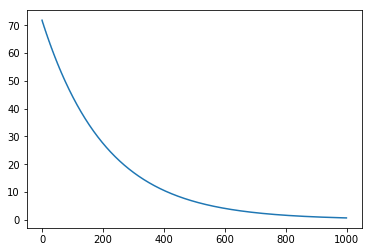

In [16]:
# エポック毎の損失値
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(sdnnr1.epoch_loss_list)
plt.show()


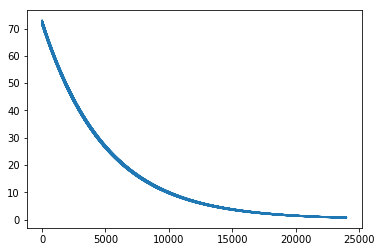

In [17]:
# ミニバッチ毎の損失値
plt.plot(sdnnr1.loss_list)
plt.show()

## 評価する

In [18]:
y_pred1 = sdnnr1.predict(X_test)

In [19]:
y_pred1[0:10]

array([[10.93316013],
       [10.93316013],
       [10.93316013],
       [10.93316013],
       [10.93316013],
       [10.93316013],
       [10.93316013],
       [10.93316013],
       [10.93316013],
       [10.93316013]])

In [20]:
m = MeanSquardError()
m.mse(y_test, y_pred1)

0.6882449730157583

# 説明
・ドロップアウトとは何か  
・近年ReLUが一般的に使われている理由  
・重みの初期化方法について  
・代表的な最適化手法について  

### 【ドロップアウトとは何か】  
**<回答>**  
過学習を制御する手法・テクニックとして利用されています。ノード（ニューロン）をランダムに選び出し、その選び出したニューロンを消去します。消去されたニューロンは信号の伝達が行われ無くなります。訓練時には、データが流れるたびに、消去するニューロンをランダムに選択します。  
機械学習にはアンサンブル学習という手法（複数のモデルを個別に学習させ、推論時にはその複数の出力を平均する）がありますが、Dropoutと近い関係にあります。Dropoutは学習時（ミニバッチ毎、レイヤー毎）にニューロンをランダムに消去することで、異なるモデルを学習させていると解釈できるからです。そして、推論時には、ニューロンの出力に対して消去した割合（例えば０.５など）を乗算することで、モデルの平均を取っています。つまり、Dropoutは、アンサンブル学習と同じ効果（擬似的に）を１つのネットワークで実現していると考えることができます。


### 【近年ReLUが一般的に使われている理由】  
**<回答>**  
シグモイドやハイパボリックタンジェントでは逆伝播時に重み・バイアスのパラメータに対して更新する勾配が消失（０）してしまう問題があるが、0以上であればその問題を解決することができるため使われているのだと思います。

### 【重みの初期化方法について】  
**<回答>**  
「ガウス分布（std=0.01）」、「Xavierの初期値」、「Heの初期値」などがあります。

### 【代表的な最適化手法について】  
**<回答>**  
最適化=optimizerとは、「最適化を行う者」ということです。代表的なものは以下です。  
・SGD（Stochastic Gradient Decent）・・・確率的勾配降下法（最適化の更新経路はジグザグのため非効率である）
$$W ← W - η\frac{∂L}{∂W}$$
・Momentum・・・最適化の更新経路が、ボールがお椀を転がるよう動作するため効率的である  
・AdaGrad・・・学習が進むにつれて学習係数（learning rate）を小さくする手法  
・Adam・・・MomentumとAdaGradを融合したような手法  

# Sprint9のMNIST（分類）にチャレンジ

In [21]:
# DNNスクラッチ分類
class ScratchDeepNeuralNetworkClassification:
    def __init__(self, n_epochs, batch_size, lr, sigma, n_nodes1, n_nodes2, n_output):
        self.n_epochs    =  n_epochs    # エポック数
        self.batch_size  = batch_size   #バッチサイズ
        self.lr                  =  lr                   # 学習率
        self.sigma          =  sigma            # シグマ
        self.n_nodes1   =  n_nodes1    # 1層目のノード数
        self.n_nodes2   =  n_nodes2    # 2層目のノード数
        self.n_output    = n_output      # 出力層のノード数
        self.loss             =  None
        self.val_loss     =  None
        
        self.loss_list = []
        self.epoch_loss_list = []
        
        #　入力層の特徴量（今回は2種類）
        # fitの中でインスタンス変数を定義するためには、ここで事前に定義する必要がある
        self.n_features = None
        
        self.fc1 = None
        self.fc2 = None
        self.fc3 = None
        
        self.activation1 = None
        self.activation2 = None
        self.activation3 = None
        self.costfunction = None
        
        self.tomo = None
    
    def fit(self, X, y, X_val=None, y_val=None):
        
        # ミニバッチ単位で処理する
        train_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=0)
        # 最適化関数（オプティマイザー）クラスをインスタンス化する
        optimizer = SGD(self.lr)

        # fitを呼び出す時に、ここで特徴量を把握すれば、コンストラクタでわざわざ定義しなくても良い
        self.n_features = X.shape[1]        

        # インスタンス化（開始） ########################################
        # 1層目
        # 全結合層クラスをインスタンス化する
        # SimpleInitializerを引数の中でクラスを呼んでいる理由は、各層で異なる初期値を与えて上げることができるため
        # optimizerを全結合で
        self.fc1 = Full_Connection(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        
        # 2層目
        # 全結合層クラスをインスタンス化する
        self.fc2 = Full_Connection(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        # 活性化関数クラスをインスタンス化する
        self.activation2 = Tanh()
        #self.activation2 = ReLU()
        
        # 3層目
        # 全結合層クラスをインスタンス化する
        self.fc3 = Full_Connection(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        
        # 出力層の活性化関数はsoftmax関数を利用する
        self.activation3 = Softmax()
        
        # 損失関数をインスタンス化する
        self.costfunction = CrossEntropyError()
        
        # インスタンス化（終了） ########################################
        
        n = 0
        # エポック単位のループ
        for epoch in range(self.n_epochs):
            n +=1            
            # ミニバッチ単位のループ
            #a = 0
            for mini_X_train, mini_y_train in train_batch:      
                #a = a +1
                # フォワード ########################################
                # 1層目
                # 全結合層（A = X・W + B）
                #print("testcode1",mini_X_train.shape)
                A1 = self.fc1.forward(mini_X_train)
                # 活性化関数（Z = 活性化関数（A））
                Z1 = self.activation1.forward(A1)

                # 2層目
                # 全結合層（A = Z・W + B）
                A2 = self.fc2.forward(Z1)
                # 活性化関数（Z = 活性化関数（A））
                Z2 = self.activation2.forward(A2)

                # 3層目
                # 全結合層（A = Z・W + B）
                A3 = self.fc3.forward(Z2)
                # 活性化関数（Z = 活性化関数（A））　　・・・分類の時はsoftmax関数
                Z3 = self.activation3.forward(A3)
                
                self.loss = self.costfunction.cee(Z3, mini_y_train)
                self.loss_list.append(self.loss)

                # バックワード ########################################
                # 3層目
                # 交差エントロピーから伝達されてきた値（-y/y_pred）を使うのではなく、softmaxから伝達される値（y_pred - y）を使う
                dA3 = self.activation3.backward(mini_y_train)
                # 全結合層のバックワード
                dZ2 = self.fc3.backward(dA3)

                # 2層目
                # 活性化関数のバックワード
                dA2 = self.activation2.backward(dZ2)
                # 全結合層のバックワード
                dZ1 = self.fc2.backward(dA2)

                # 1層目
                # 活性化関数のバックワード
                dA1 = self.activation1.backward(dZ1)
                # 全結合層のバックワード
                dZ0 = self.fc1.backward(dA1)
            
            #print(a)
            self.epoch_loss_list.append(self.loss)
            print(n)
    def predict(self, X):
        
        # 1層目  ############################################
        A1 = self.fc1.forward(X)
        # この時点ではOK
        #print(A1.shape) # (292, 500)
        #print(A1) # バラバラな値である
        self.tomo = A1
        
        Z1 = self.activation1.forward(A1)
        #print(Z1.shape) # (292, 500)
        #print(Z1)

        # 2層目  ############################################
        A2 = self.fc2.forward(Z1)
        #print(A2.shape)
        #print(A2)
        
        Z2 = self.activation2.forward(A2)
        #print("Z2.shape : ",Z2.shape)
        #print(Z2)
        #print(np.unique(Z2))

        # 3層目  ############################################
        A3 = self.fc3.forward(Z2)
        #print(A3.shape)
        Z3 = self.activation3.forward(A3)
        
        return Z3

In [22]:
class Full_Connection:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    n_nodes1 :  int
    n_nodes2 :  int
    initializer :  初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    
    # コンストラクタで重みやバイアスの初期化をする
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):

        # 全結合層のコンストラクタに初期化方法のインスタンスを渡したい
        # ノード数を保持する
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.sigma = initializer.sigma
        
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        # 重み・バイアスを初期化
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        #print("doudesuka",n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        #print("★★★★★★★",self.B.shape)
        
        # 引数で受け取ったoptimizer（最適化クラス）をインスタンス変数として持つ
        self.optimizer = optimizer
        
        # ここで初期化が必要。。
        self.X = None
        self.dB = None
        self.dW = None
        self.A = None
        
        # ドロップアウト用
        self.mask = None
        self.dropout_ratio = 0.5
    
    def forward(self, X):
        """
        X  :  配列とシェイプ  （batch_size,  n_nodes1）
        A  :  配列とシェイプ  （batch_size, n_nodes2）
        """
        """
        ドロップアウトする要素（False）としない要素（True）に分ける
        """
        #self.X = X.copy()
        #self.mask = np.random.rand(*self.X.shape) > self.dropout_ratio
        #self.X = self.X * self.mask
        
        # 入力Xをインスタンス変数として保持
        self.X = X.copy()
        
        # 全結合はここで定義している
        self.A = np.dot(self.X, self.W) + self.B
        
        return self.A

    
    def backward(self, dA):
        
        """
        dA  :  後ろから流れてきた勾配(batch_size, n_nodes2)
        dZ  :   前に流す勾配　（batch_size, n_nodes1）
        """
        # バイアスの勾配は、forward時に加算演算なので、
        # 前から受け取った勾配をそもまま利用する
        self.dB = dA
        
        # forward時に活性化関数を通ったXを利用する。Zに相当する
        # 前から受け取ったもdAと、dot積をとる。ひっくり返すところの処理。乗算演算なので
        self.dW = np.dot(self.X.T, dA)
        
        # 後ろに流す勾配
        dZ = np.dot(dA, self.dW.T)
        
        # 引数として自身のインスタンスselfを渡すこともできる
        # 層の重みの更新が可能である
        # self.optimizer.update(self)だけでもOK
        # 各層のbackwardの処理の中で、重みパラメータとバイアスを更新する処理です
        # sprint9の時は最後にまとめて更新していたが、その層の重みとバイアスが求まったタイミングでリアルタイムで更新する
        # また、ここでselfに代入しなくても動作するらしいです。
        #print("fcで最適化する")
        self = self.optimizer.update(self)        
        
        return dZ
    
    def dropout():        
        pass

In [23]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import numpy as np

# 保存先を指定
mnist_dir = "/Users/tsuneo/git/diveintocode-term2/mnist_data"

# MNISTの読み込み
mnist = fetch_mldata('MNIST original', data_home=mnist_dir)

# trainとtestに分割する
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.14285, shuffle=False)

print("--int型へ変更前--")
print(X_train.dtype)
print(y_test.dtype)

# ラベルをint型にしておく
y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)

print("--int型へ変更後--")
print(X_train.dtype)
print(y_test.dtype)

--int型へ変更前--
uint8
float64
--int型へ変更後--
uint8
int64


In [24]:
# 特徴量だけを、float型へ変換している
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

# 最大値・最小値の確認（処理前）
print(X_train.max())
print(X_train.min())
print("----")

# 正則化？正規化？標準化？している
X_train /= 255
X_test /= 255

# 最大値・最小値の確認（処理前）
print(X_train.max())
print(X_train.min())

255.0
0.0
----
1.0
0.0


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print("X_train    :",X_train.shape)
print("X_val    :",X_val.shape)

X_train    : (48000, 784)
X_val    : (12000, 784)


In [26]:
#  one-hot表現にする
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

# 教師ラベルだけ変換する
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])

# shapeの確認
print("y_train.shape    　　　　　　　　　　　　　　　　:   ",y_train.shape)
print("y_train_one_hot.shape    :   ",y_train_one_hot.shape)
print("y_train_one_hot.型  　　　　　　  :   ",y_train_one_hot.dtype)
print("------")
print("y_test.shape  　　　　　　　　　　　　　　　　  :   ",y_val.shape)
print("y_test_one_hot.shape    :   ",y_val_one_hot.shape)
print("y_test_one_hot.型　　　　　　    :   ",y_val_one_hot.dtype)

y_train.shape    　　　　　　　　　　　　　　　　:    (48000,)
y_train_one_hot.shape    :    (48000, 10)
y_train_one_hot.型  　　　　　　  :    float64
------
y_test.shape  　　　　　　　　　　　　　　　　  :    (12000,)
y_test_one_hot.shape    :    (12000, 10)
y_test_one_hot.型　　　　　　    :    float64


In [36]:
sdnnc1 = ScratchDeepNeuralNetworkClassification(n_epochs=15, batch_size=100, lr=0.0000001,sigma=0.01, n_nodes1=400, n_nodes2=200, n_output=10)
sdnnc1.fit(X_train, y_train_one_hot)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [35]:
len(sdnnc1.loss_list)

4800

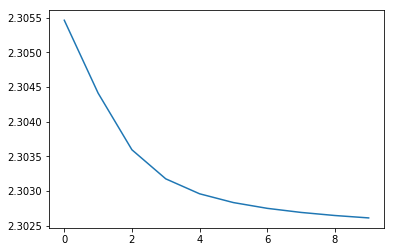

In [29]:
# エポック毎のlossを描画
plt.plot(sdnnc1.epoch_loss_list)
plt.show()

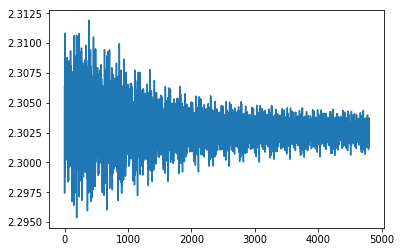

In [30]:
# ミニバッチ毎の損失値
plt.plot(sdnnc1.loss_list)
plt.show()

In [31]:
y_pred1 = sdnnc1.predict(X_val)
y_pred1[4]

array([0.10152583, 0.10103768, 0.09871647, 0.09924521, 0.09922698,
       0.10092989, 0.10092123, 0.09960976, 0.0993024 , 0.09948455])

In [32]:
y_val_one_hot.shape

(12000, 10)

In [33]:
y_pred1.shape

(12000, 10)

In [34]:
# accuracyスコアがうまく実行されません
from sklearn.metrics import accuracy_score
acc1 = accuracy_score(y_val_one_hot, y_pred1)
acc1

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets